In [2]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from cellpose import models, io
from pathlib import Path
from tnia.deeplearning.dl_helper import collect_training_data
from tnia.plotting.projections import show_xyz_slice, show_xyz_max, show_xy_zy_max

# Set-up paths

In [3]:
parent_dl_path = r'../../models'
model_path = os.path.join(parent_dl_path, r'models')
print(model_path)
patches_path = os.path.join(parent_dl_path, r'patches')
print(patches_path)

../../models\models
../../models\patches


## Get training data

../../data/deep learning training/spheres_small_noise_high_na_high\train
25

25
25


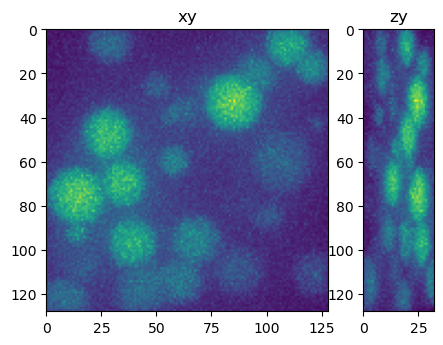

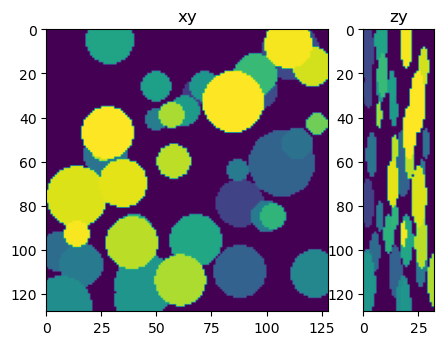

In [5]:
data_path = r'../../data/deep learning training/'
dl_path = r'../../models'

data_path1 = os.path.join(data_path, 'spheres_small_noise_high_na_high', 'train')

paths = [data_path1]

X = []
Y = []

for path in paths:
    X_, Y_ = collect_training_data(path, sub_sample=1, downsample=False, normalize_truth=False, training_multiple=16)

    print(path)
    print(len(X_))
    print()
    X.extend(X_)
    Y.extend(Y_)

print(len(X))
print(len(Y))

fig = show_xy_zy_max(X[0], figsize=(5,5))
fig = show_xy_zy_max(Y[0], figsize=(5,5))

## Format training data for Cellpose

Cellpose needs a list of 2D training images

In [6]:
X_2D = []
Y_2D = []
for X_, Y_ in zip(X, Y):
    for i in range(X_.shape[0]):
        X_2D.append(X_[i,:,:])
        Y_2D.append(Y_[i,:,:])

print(len(X_2D), len(Y_2D))
print(X_2D[0].shape, Y_2D[0].shape)

limit = 100
X_2D = X_2D[:limit]
Y_2D = Y_2D[:limit]

print(len(X_2D), len(Y_2D))

800 800
(128, 128, 1) (128, 128)
100 100


## Verify data

Take a look at the shape of the data and one of the images to verify that we loaded it correctly

(128, 128, 1) (128, 128)
-0.13793103 0.6551724


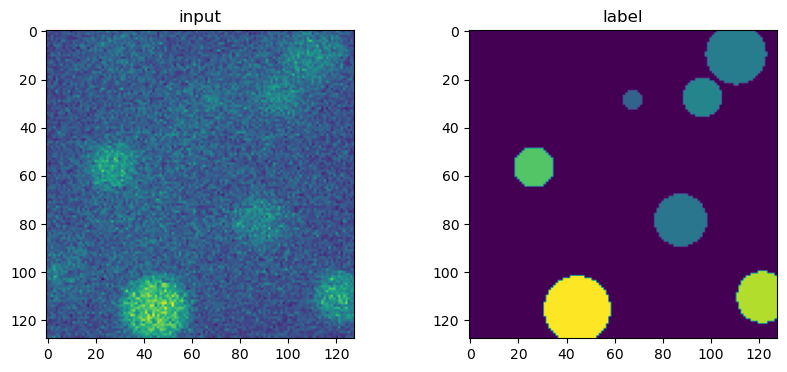

In [7]:
print(X_2D[0].shape, Y_2D[0].shape)
print(X_2D[0].min(), X_2D[0].max())
fig=imshow_multi2d([X_2D[2], Y_2D[2]], ['input', 'label'], 1,2)

## Create training and testing sets

In [8]:

X_ = X_2D.copy()
Y_ = Y_2D.copy()

for i in range(len(Y_)):
    Y_[i] = Y_[i].astype('uint8')

X_train = X_[:int(len(X_)*0.8)]
Y_train = Y_[:int(len(Y_)*0.8)]
X_test = X_[int(len(X_)*0.8):]
Y_test = Y_[int(len(Y_)*0.8):]

print('Number of images', len(X_))
print('Number of training images', len(X_train))
print('Number of test images ', len(X_test))


Number of images 100
Number of training images 80
Number of test images  20


In [8]:
import os

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=True, model_type=None, pretrained_model=os.path.join(model_path,'models','cellpose_model1'))

2024-01-05 06:24:57,107 [INFO] WRITING LOG OUTPUT TO C:\Users\bnort\.cellpose\run.log
2024-01-05 06:24:57,108 [INFO] 
cellpose version: 	2.2.3 
platform:       	win32 
python version: 	3.9.16 
torch version:  	2.1.2+cpu
2024-01-05 06:24:57,109 [WARNING] pretrained model has incorrect path
2024-01-05 06:24:57,110 [INFO] >> cyto << model set to be used
2024-01-05 06:24:57,144 [INFO] TORCH CUDA version not installed/working.
2024-01-05 06:24:57,146 [INFO] >>>> using CPU
2024-01-05 06:24:57,639 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


In [9]:
new_model_path = model.train(X_train, Y_train, 
                              #test_data=X_val,
                              #test_labels=Y_val,
                              channels=[0,1], 
                              save_path=model_path, 
                              n_epochs=20,
                              #learning_rate=learning_rate, 
                              #weight_decay=weight_decay, 
                              nimg_per_epoch=200,
                              model_name='cellpose_try')

2024-01-05 06:25:05,795 [INFO] computing flows for labels


100%|██████████| 80/80 [00:00<00:00, 211.09it/s]

2024-01-05 06:25:06,205 [WARNING] 21 train images with number of masks less than min_train_masks (5), removing from train set


2024-01-05 06:25:06,689 [INFO] >>>> median diameter set to = 30
2024-01-05 06:25:06,690 [INFO] >>>> mean of training label mask diameters (saved to model) 15.622
2024-01-05 06:25:06,692 [INFO] >>>> training network with 2 channel input <<<<
2024-01-05 06:25:06,693 [INFO] >>>> LR: 0.20000, batch_size: 8, weight_decay: 0.00001
2024-01-05 06:25:06,694 [INFO] >>>> ntrain = 59
2024-01-05 06:25:06,695 [INFO] >>>> nimg_per_epoch = 200
2024-01-05 06:25:46,529 [INFO] Epoch 0, Time 39.8s, Loss 1.9222, LR 0.0000
2024-01-05 06:26:24,388 [INFO] saving network parameters to ../../models\models\models/cellpose_try
2024-01-05 06:28:55,988 [INFO] Epoch 5, Time 229.3s, Loss 0.3290, LR 0.1111
2024-01-05 06:32:06,116 [INFO] Epoch 10, Time 419.4s, Loss 0.1607, LR 0.2000
2024-01-05 06:37:43,947 [INFO] saving network parameters to ../../models\models\models/cellpose_try


finished training
diameter 5
diameter 10
diameter 25
diameter 50


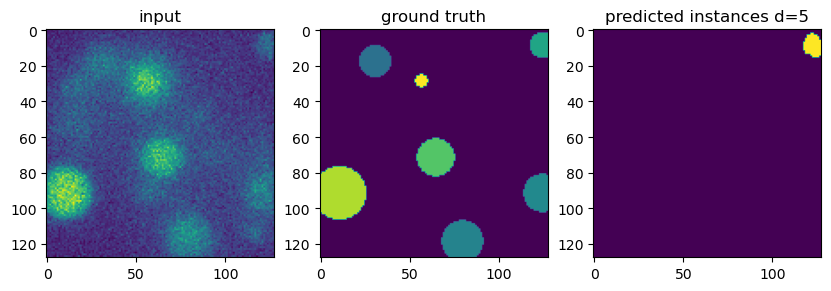

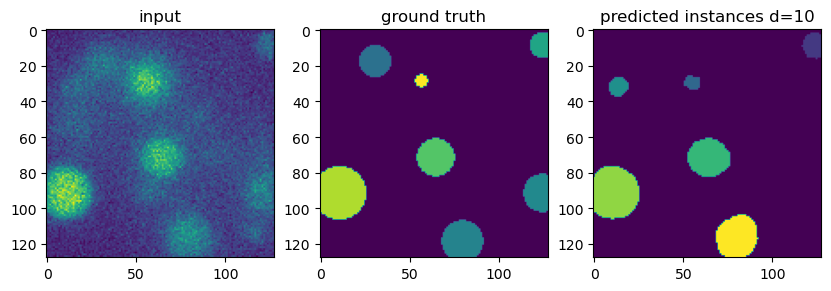

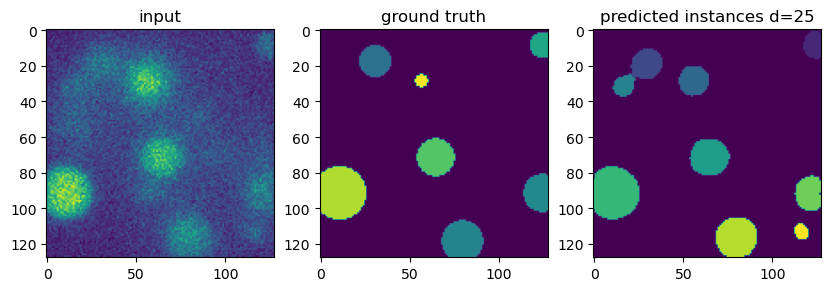

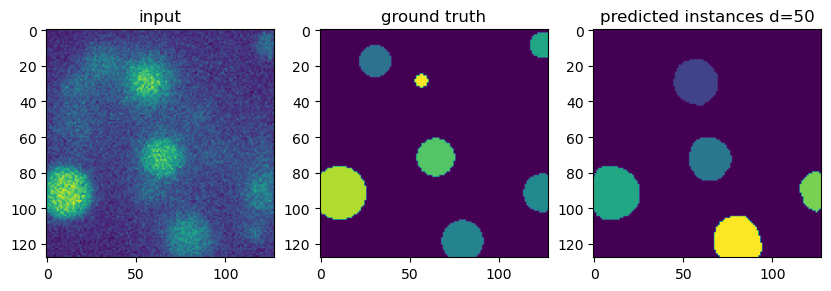

In [30]:
print('finished training')

n = 5
z=4
diameters = [5, 10, 30, 50]

X_test_ = X[n][z]
Y_test_ = Y[n][z]

for diameter in diameters:
    print('diameter', diameter)
    masks = model.eval(X_test_, channels=[0, 1,2],diameter=diameter)[0]
    fig = imshow_multi2d([X_test_, Y_test_, masks],['input','ground truth','predicted instances d='+str(diameter)],1,3)


In [31]:
masks = model.eval(X[n], channels=[0, 1,2],diameter=diameter, do_3D=True, anisotropy=3)[0]

2024-01-05 07:07:07,164 [INFO] multi-stack tiff read in as having 32 planes 1 channels
2024-01-05 07:07:07,196 [INFO] running YX: 32 planes of size (128, 128)
2024-01-05 07:07:07,589 [INFO] 100%|##########| 1/1 [00:00<00:00,  2.59it/s]
2024-01-05 07:07:07,603 [INFO] running ZY: 128 planes of size (32, 128)
2024-01-05 07:07:08,746 [INFO] 100%|##########| 4/4 [00:01<00:00,  3.52it/s]
2024-01-05 07:07:08,770 [INFO] running ZX: 128 planes of size (32, 128)
2024-01-05 07:07:09,888 [INFO] 100%|##########| 4/4 [00:01<00:00,  3.60it/s]
2024-01-05 07:07:09,915 [INFO] network run in 2.75s
2024-01-05 07:07:10,606 [INFO] masks created in 0.69s


In [32]:
import napari
viewer = napari.Viewer()
viewer.add_image(X[n].squeeze())
viewer.add_labels(Y[n].astype('uint16'))
viewer.add_labels(masks)

<Labels layer 'masks' at 0x24ff035f5b0>

In [26]:
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=None, channel_axis=None, z_axis=None, normalize=True, invert=False, rescale=None, diameter=None, do_3D=False, anisotropy=None, net_avg=False, augment=False, tile=True, tile_overlap=0.1, resample=True, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, compute_masks=True, min_size=15, stitch_threshold=0.0, progress=None, loop_run=False, model_loaded=False) method of cellpose.models.CellposeModel instance
    segment list of images x, or 4D array - Z x nchan x Y x X
    
    Parameters
    ----------
    x: list or array of images
        can be list of 2D/3D/4D images, or array of 2D/3D/4D images
    
    batch_size: int (optional, default 8)
        number of 224x224 patches to run simultaneously on the GPU
        (can make smaller or bigger depending on GPU memory usage)
    
    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
 